In [1]:
%matplotlib inline 

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from numpy import array
from numpy import hstack

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu, elu
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
from tensorflow.keras.layers import Flatten, Dropout  
from tensorflow.keras.layers import Layer, Input

from keras.layers import GRU

from sklearn.metrics import r2_score

In [2]:
# print package versions
print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.21.6
tensorflow version: 2.9.2
pandas version: 1.3.5


In [3]:
# set random seed for reproducible results
SEED = 42004
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.compat.v1.set_random_seed(SEED)

In [4]:
# use if running through Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Kiholo Dataset for 1D-CNN

Data Sources: Dulai, H., Kamenik, J., Waters, C. A., Kennedy, J., Babinec, J., Jolly, J., & Williamson, M. (2016). Autonomous long-term gamma-spectrometric monitoring of submarine groundwater discharge trends in Hawaii. Journal of Radioanalytical and Nuclear Chemistry, 307(3), 1865–1870. https://doi.org/10.1007/s10967-015-4580-9

McKenzie, T., Dulai, H., & Fuleky, P. (2021). Traditional and novel time-series approaches reveal submarine groundwater discharge dynamics under baseline and extreme event conditions. Scientific Reports, 11(1), 1–14. https://doi.org/10.1038/s41598-021-01920-0

Meteorological data: RAWS USA Climate Archive. Puu Waawaa, Hawaii. Accessed from: https://raws.dri.edu/cgi-bin/rawMAIN.pl?hiHPUW

In [46]:
# load Kiholo dataset for training and validation
# import data; if using Google Colab, folder structure will be:
# "/content/drive/My Drive/folder_name/filename.xlsx"

data = pd.read_excel('1DCNN_Rn_DL_data_S2.xlsx', sheet_name = "Kiholo")

data.columns = ['datetime', 'depth_m',
                 'ctdtemp_C', 'ctdsal', 'Rn_Bqm3'] 

# convert first column to datetime format
data.datetime = pd.to_datetime(data.datetime)

# index by datetime
data.set_index(data.datetime, inplace = True)
data = data.drop('datetime', axis = 1)
data.head()

,depth_m,ctdtemp_C,ctdsal,Rn_Bqm3
datetime,,,,
2014-03-14 02:00:00,0.278,24.3675,16.8750,221.610947
2014-03-14 03:00:00,0.296,23.7625,15.3425,6.666667
2014-03-14 04:00:00,0.269,23.3425,14.3500,6.666667
2014-03-14 05:00:00,0.178,22.8300,13.2225,6.666667
2014-03-14 06:00:00,0.051,22.6050,13.6600,418.577742


In [47]:
# pre-processing: 12 hour moving average
data_12hr = data.rolling(window = 12, center = True).mean()
data_12hr = data_12hr.dropna()
data_12hr.head()

,depth_m,ctdtemp_C,ctdsal,Rn_Bqm3
datetime,,,,
2014-03-14 08:00:00,0.003083,23.252083,16.678958,122.365785
2014-03-14 09:00:00,-0.009833,23.305625,17.531875,104.453762
2014-03-14 10:00:00,-0.022667,23.406042,18.565417,104.453762
2014-03-14 11:00:00,-0.034250,23.476458,19.478125,104.453762
2014-03-14 12:00:00,-0.043750,23.541458,20.238542,104.453762


In [48]:
print(min(data_12hr['depth_m']))
print(min(data_12hr['ctdtemp_C']))
print(min(data_12hr['ctdsal']))
print(min(data_12hr['Rn_Bqm3']))

data_12hr['depth_m'] = data_12hr['depth_m'] + abs((min(data_12hr['depth_m'])))
print(min(data_12hr['depth_m']))

data_12hr['Rn_Bqm3'] = data_12hr['Rn_Bqm3'] + abs((min(data_12hr['Rn_Bqm3'])))
print(min(data_12hr['Rn_Bqm3']))

-0.2336666666666667
22.304166666666664
9.043407155979166
-41.15864177255233
0.0
0.0


In [49]:
# normalize Kiholo data
data_norm = data_12hr
data_norm['depth_m'] = (data_12hr['depth_m'] - min(data_12hr['depth_m'])) / (max(data_12hr['depth_m']) - min(data_12hr['depth_m']))
data_norm['ctdtemp_C'] = (data_12hr['ctdtemp_C'] - min(data_12hr['ctdtemp_C'])) / (max(data_12hr['ctdtemp_C']) - min(data_12hr['ctdtemp_C']))
data_norm['ctdsal'] = (data_12hr['ctdsal'] - min(data_12hr['ctdsal'])) / (max(data_12hr['ctdsal']) - min(data_12hr['ctdsal']))
data_norm['Rn_Bqm3'] = (data_12hr['Rn_Bqm3'] - min(data_12hr['Rn_Bqm3'])) / (max(data_12hr['Rn_Bqm3']) - min(data_12hr['Rn_Bqm3']))

data_norm.head()

,depth_m,ctdtemp_C,ctdsal,Rn_Bqm3
datetime,,,,
2014-03-14 08:00:00,0.409838,0.150373,0.409740,0.104615
2014-03-14 09:00:00,0.387478,0.158867,0.455509,0.093156
2014-03-14 10:00:00,0.365263,0.174797,0.510971,0.093156
2014-03-14 11:00:00,0.345211,0.185967,0.559949,0.093156
2014-03-14 12:00:00,0.328765,0.196279,0.600754,0.093156


# Multistep 1DConv CNN for Kiholo Data

In [50]:
# code modified from "Deep Learning for Time Series Forecasting: Predict the 
# Future with MLPs, CNNs and LSTMs in Python" by Jason Brownlee
# https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/

# split Kiholo sequence into samples - take each sequence and make from n steps in and out
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end
    end_ix = i + n_steps_in # dataset length + number of steeps fed to model
    out_end_ix = end_ix + n_steps_out # previous step + number of steps to predict
    # stop once outside of dataset length
    if out_end_ix > len(sequences):
      break
    # gather input and output
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

# define input sequence
in_seq1 = data_norm['depth_m'].to_numpy()
in_seq2 = data_norm['ctdtemp_C'].to_numpy()
in_seq3 = data_norm['ctdsal'].to_numpy()

# define output sequence
out_seq = data_norm['Rn_Bqm3'].to_numpy()

# convert input and output to [rows, columns] structure for CNN
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))

out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack input and output columns (ie to windows)
dataset = hstack((in_seq1, in_seq2, in_seq3, out_seq))

# number of time steps in/out
n_steps_in, n_steps_out = 6, 1

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

# nunber of features
n_features = X.shape[2]

# setup for train/validation split
N = len(X)
t = np.arange(0,N)

# split into training and validation data
# 80/20
Tp_data = int(len(X) * 0.8)
Tp_data

(15328, 6, 4) (15328, 1, 4)


12262

In [51]:
X_train = X[0:Tp_data,:]
y_train = y[0:Tp_data]

X_test = X[Tp_data:N,:]
y_test = y[Tp_data:N]

In [52]:
# define model
model = Sequential()
model.add(Conv1D(90, 2, activation = 'relu', input_shape = 
                 (n_steps_in, n_features)))
model.add(Conv1D(90, 2, activation = 'relu'))
model.add(MaxPooling1D())

model.add(GRU(20, activation = 'relu', return_sequences = True))
model.add(GRU(20, activation = 'relu', return_sequences = True))
model.add(Flatten())

model.add(Dense(units = 250, activation = 'elu'))
model.add(Dense(units = 125, activation = 'elu'))
model.add(Dense(units = 50, activation = 'elu'))
model.add(Dense(n_output))

# learning rate optimizer
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 7000,
    decay_rate = 0.94,
    staircase = False) 

# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 25)

# compile 1D-Conv with learning rate optimizer and early stopping
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
              loss ='mae', 
              metrics = ['mean_absolute_error', 'RootMeanSquaredError'])

In [53]:
# Fit the model
hist = model.fit(X_train, y_train, 
                 validation_data = (X_test, y_test), 
                 epochs = 5000, 
                 batch_size = 100, 
                 callbacks = [callback], 
                 verbose = 1)

Epoch 1/5000
123/123 [==============================] - 5s 18ms/step - loss: 0.1794 - mean_absolute_error: 0.1794 - root_mean_squared_error: 0.2401 - val_loss: 0.0978 - val_mean_absolute_error: 0.0978 - val_root_mean_squared_error: 0.1208
Epoch 2/5000
123/123 [==============================] - 2s 14ms/step - loss: 0.0910 - mean_absolute_error: 0.0910 - root_mean_squared_error: 0.1188 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747 - val_root_mean_squared_error: 0.0944
Epoch 3/5000
123/123 [==============================] - 2s 14ms/step - loss: 0.0651 - mean_absolute_error: 0.0651 - root_mean_squared_error: 0.0854 - val_loss: 0.0556 - val_mean_absolute_error: 0.0556 - val_root_mean_squared_error: 0.0704
Epoch 4/5000
123/123 [==============================] - 2s 15ms/step - loss: 0.0408 - mean_absolute_error: 0.0408 - root_mean_squared_error: 0.0567 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0521
Epoch 5/5000
123/123 [======================

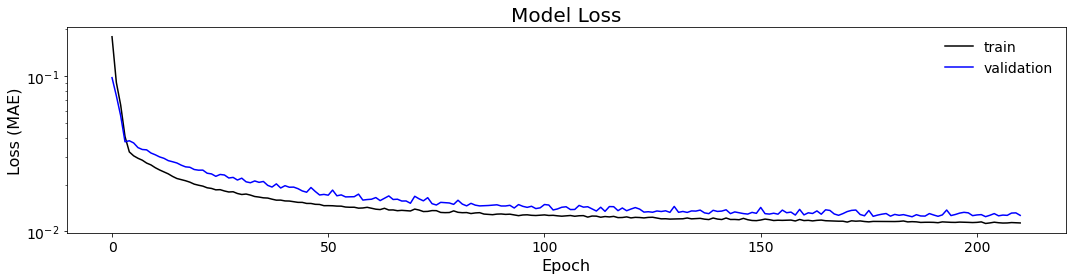

In [54]:
# plot model convergence
plt.figure(figsize = (15,4))
plt.semilogy(hist.history['loss'], color = 'black')
plt.semilogy(hist.history['val_loss'], color = 'blue')
plt.tick_params(labelsize = 14)

plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss (MAE)', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['train', 'validation'], loc='upper right', frameon = False, 
           fontsize = 14)

plt.tight_layout()
plt.show()

In [55]:
# evaluate Kiholo model
# prediction for Kiholo data (with train/validation split)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.concatenate((y_train_pred,y_test_pred), axis = 0)

test_loss_a = model.evaluate(X_train, y_train)
test_loss_b = model.evaluate(X_test, y_test)

print(test_loss_a)
print(test_loss_b)

96/96 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0261
[0.011250832118093967, 0.011250832118093967, 0.02810392901301384]
[0.012670786119997501, 0.012670786119997501, 0.026121506467461586]


In [56]:
# Kiholo training and validation r^2
R2_train = r2_score(y_train[:,3], y_train_pred[:,3], 
                    multioutput = 'variance_weighted')

R2_test = r2_score(y_test[:,3], y_test_pred[:,3], 
                   multioutput = 'variance_weighted')

print(R2_train)
print(R2_test)

0.9697435758150265
0.923456141737801


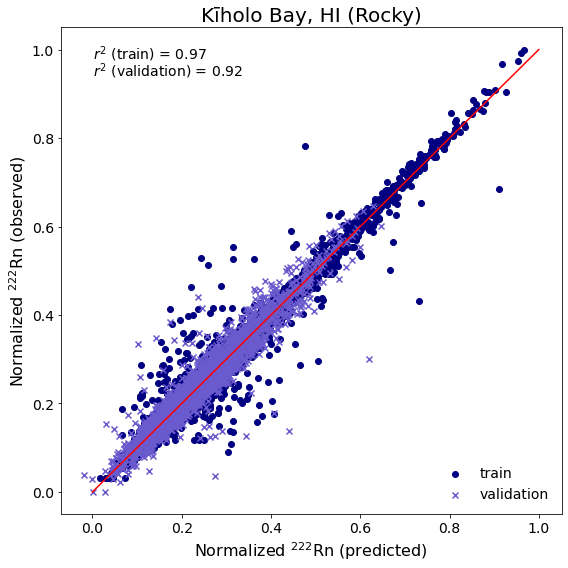

In [57]:
# y vs y pred 45 degree mismatch for Kiholo (with train/validation split)
plt.figure(figsize = (8,8))
plt.scatter(y_train_pred[:,3], y_train[:,3], alpha = 1, label = 'train', color = 'navy')#, color = 'lightblue')
plt.scatter(y_test_pred[:,3], y_test[:,3], alpha = 1, label = 'validation', marker ='x', color = 'slateblue')#, color = 'darkblue')

plt.legend(loc = 'lower right', frameon=False, fontsize = 14)
plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('Kīholo Bay, HI (Rocky)', fontsize = 20)
 
# plot 45 degree line
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 

plt.tick_params(labelsize = 14)

# plot r2 results on plot
plt.text(0.001, 0.98, '$r^2$ (train) = %0.2f' % R2_train, fontsize = 14)
plt.text(0.001, 0.94, '$r^2$ (validation) = %0.2f' % R2_test, fontsize = 14)
plt.tight_layout()
plt.show()

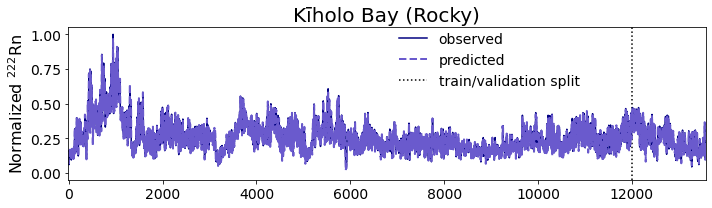

In [58]:
# plot predicted Rn with respect to time
plt.figure(figsize=(10, 3))
plt.plot(y[:,3], label='observed', color = 'navy')
plt.plot(y_pred[:,3], label='predicted', linestyle = 'dashed', linewidth = 2, 
         color = 'slateblue')

plt.vlines(12000, -0.05, 1.05, colors='k', linestyles='dotted', label='train/validation split')

plt.tick_params(labelsize = 14)

plt.title('Kīholo Bay (Rocky)', fontsize = 20)
plt.ylabel('Normalized $^{222}$Rn', fontsize = 16)

plt.legend(bbox_to_anchor=(.5, 1.05), fontsize = 14, frameon = False)
plt.xlim(-15, 13570)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# Florida SGD Validation (Example)

Data source: Santos, I. R., Burnett, W. C., Chanton, J., Dimova, N., & Peterson, R. N. (2009). Land or ocean?: Assessing the driving forces of submarine groundwater discharge at a coastal site in the gulf of mexico. Journal of Geophysical Research: Oceans, 114(4), 1–11. https://doi.org/10.1029/2008JC005038

Meteorological data source: FAWN (Florida Automated Weather Network (FAWN). Carrabell Station. https://fawn.ifas.ufl.edu/data/reports/

Example code that can be modified for other datasets, gap filling, etc.




In [30]:
# import Florida Rn dataset
FL_raw = pd.read_excel('1DCNN_Rn_DL_data_S2.xlsx', sheet_name = "FSUCML")

FL_raw.columns = ['datetime', 'depth_m', 'CTDtemp_C', 'CTDsal', 'Rn_Bqm3']

# convert first column to datetime format
FL_raw.datetime = pd.to_datetime(FL_raw.datetime)

# index by datetime
FL_raw.set_index(FL_raw.datetime, inplace = True)

# index by datetime
FL_raw.set_index(FL_raw.datetime, inplace = True)
FL_raw = FL_raw.drop('datetime', axis = 1)

FL = FL_raw

# pre-processing: 12 hour MA 
FL_12hr =  FL.rolling(window = 12, center = True).mean()

FL_12hr = FL_12hr.dropna()
FL_12hr.head()

,depth_m,CTDtemp_C,CTDsal,Rn_Bqm3
datetime,,,,
2005-11-18 20:09:00,1.397233,16.474583,33.678333,44.576667
2005-11-18 21:09:00,1.432070,16.315417,33.711167,49.540833
2005-11-18 22:09:00,1.461615,16.140417,33.727333,54.666667
2005-11-18 23:09:00,1.478037,15.949583,33.738667,55.549167
2005-11-19 00:09:00,1.484471,15.774583,33.748667,56.007500


In [31]:
# check minimum values, rescale if necessary
FL_12hr.min()

depth_m       0.829202
CTDtemp_C    10.155625
CTDsal       24.947167
Rn_Bqm3       0.000000
dtype: float64

In [32]:
# normalize FL data
FL_norm = FL_12hr
FL_norm['depth_m'] = (FL_12hr['depth_m'] - min(FL_12hr['depth_m'])) / (max(FL_12hr['depth_m']) - min(FL_12hr['depth_m']))
FL_norm['CTDtemp_C'] = (FL_12hr['CTDtemp_C'] - min(FL_12hr['CTDtemp_C'])) / (max(FL_12hr['CTDtemp_C']) - min(FL_12hr['CTDtemp_C']))
FL_norm['CTDsal'] = (FL_12hr['CTDsal'] - min(FL_12hr['CTDsal'])) / (max(FL_12hr['CTDsal']) - min(FL_12hr['CTDsal']))
FL_norm['Rn_Bqm3'] = (FL_12hr['Rn_Bqm3'] - min(FL_12hr['Rn_Bqm3'])) / (max(FL_12hr['Rn_Bqm3']) - min(FL_12hr['Rn_Bqm3']))

In [33]:
# separate input (owl, ctdtemp, salinity) and output (Rn) variables 
FL_norm_y = FL_norm['Rn_Bqm3']
FL_norm = FL_norm.drop(['Rn_Bqm3'], axis = 1)
FL_norm.head()

,depth_m,CTDtemp_C,CTDsal
datetime,,,
2005-11-18 20:09:00,0.323876,0.239066,0.740805
2005-11-18 21:09:00,0.343739,0.233044,0.743591
2005-11-18 22:09:00,0.360585,0.226423,0.744962
2005-11-18 23:09:00,0.369948,0.219203,0.745924
2005-11-19 00:09:00,0.373617,0.212583,0.746772


In [34]:
# code modified from "Deep Learning for Time Series Forecasting: Predict the 
# Future with MLPs, CNNs and LSTMs in Python" by Jason Brownlee
# https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/

# split Florida multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X_FL, y_FL = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the dataset
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
    X_FL.append(seq_x)
    y_FL.append(seq_y)
  return array(X_FL), array(y_FL)

# input sequence
in_seq1_FL = FL_norm['depth_m'] .to_numpy()
in_seq2_FL = FL_norm['CTDtemp_C'].to_numpy()
in_seq3_FL = FL_norm['CTDsal'] .to_numpy()

# output
out_seq_FL = FL_norm_y.to_numpy()

# convert to [rows, columns] structure
in_seq1_FL = in_seq1_FL.reshape((len(in_seq1_FL), 1))
in_seq2_FL = in_seq2_FL.reshape((len(in_seq2_FL), 1))
in_seq3_FL = in_seq3_FL.reshape((len(in_seq3_FL), 1))

out_seq_FL = out_seq_FL.reshape((len(out_seq_FL), 1))

# horizontally stack columns
dataset_FL = hstack((in_seq1_FL, in_seq2_FL, in_seq3_FL, out_seq_FL))

# number of time steps
n_steps_in, n_steps_out = 6, 1

In [35]:
# convert into input/output
X_FL, y_FL = split_sequences(dataset_FL, n_steps_in, n_steps_out)
print(X_FL.shape, y_FL.shape)

# flatten output
n_output = y_FL.shape[1] * y_FL.shape[2]
y_FL = y_FL.reshape((y_FL.shape[0], n_output))

# number of features
n_features = X_FL.shape[2]

(14970, 6, 4) (14970, 1, 4)


In [45]:
# evaluate Florida dataset using model trained on Kiholo data
y_test_FL = model.predict(X_FL)
test_loss_FL = model.evaluate(X_FL, y_FL[:,3])
print(test_loss_FL)

468/468 [==============================] - 3s 5ms/step


In [41]:
# r^2
R2_FL = r2_score(y_FL[:,3], y_test_FL[:,3], multioutput = 'variance_weighted')
print(R2_FL)

0.9927080445979801


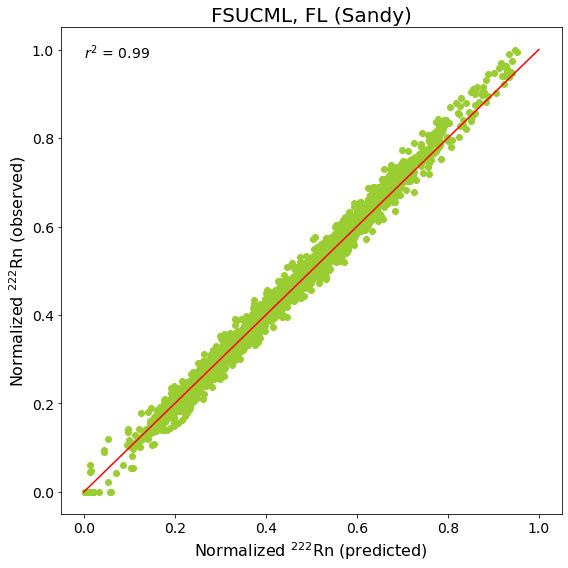

In [42]:
# y vs y pred 45 degree mismatch for data (with train/test split)
plt.figure(figsize = (8,8))

plt.scatter(y_test_FL[:,3], y_FL[:,3], color = 'yellowgreen')

plt.xlabel('Normalized $^{222}$Rn (predicted)', fontsize = 16)
plt.ylabel('Normalized $^{222}$Rn (observed)', fontsize = 16)
plt.title('FSUCML, FL (Sandy)', fontsize = 20)
 
x1 = np.linspace(0, 1, 1000)
plt.plot(x1,x1, c = "red") 
plt.text(0.001, 0.98, '$r^2$ = %0.2f' % R2_FL, fontsize = 14)

plt.tick_params(labelsize = 14)
plt.tight_layout()

plt.show()

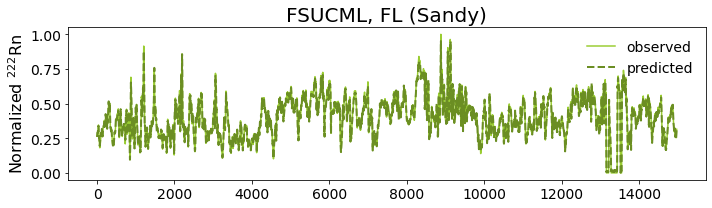

In [43]:
# plot predicted
plt.figure(figsize = (10, 3))

plt.plot(y_FL[:,3], label ='observed', color = 'yellowgreen')
plt.plot(y_test_FL[:,3], 
         label = 'predicted', 
         linestyle = 'dashed', 
         linewidth = 2, 
         color = 'olivedrab')

plt.ylabel('Normalized $^{222}$Rn', fontsize = 16)
plt.title("FSUCML, FL (Sandy)", fontsize = 20)

plt.legend(fontsize = 14, frameon = False)
 
plt.tick_params(labelsize = 14)

#plt.xlim(-15, 3200)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()